# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [23]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy as sc
from sklearn.decomposition import PCA
from matplotlib import offsetbox
from sklearn.manifold import Isomap

**1.1 Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.**

In [6]:
en_countries = ['au','ca', 'gb', 'nz', 'us']
page_list = range(1,5)

def store_scrape(id_):
    df_final = pd.DataFrame(columns = ['im:version','im:rating', 'title', 'content'])
    for country in en_countries:
        for page in page_list:
            r = requests.get(f"https://itunes.apple.com/{country}/rss/customerreviews/id={id_}/page={page}/sortby=mostrecent/json").json()
            df = pd.DataFrame(r['feed']['entry'])
            df['title'] = df['title'].apply(lambda x: x['label'])
            df['im:version'] = df['im:version'].apply(lambda x: x['label'])
            df['im:rating'] = df['im:rating'].apply(lambda x: x['label'])
            df['content'] = df['content'].apply(lambda x: x['label'])
            df['app'] = id_
            df = df.drop(columns=['author', 'id', 'link', 'im:voteSum', 'im:contentType', 'im:voteCount'])
            df_final = pd.concat([df_final, df], axis = 0)
    return df_final

In [7]:
candycrush = store_scrape(553834731)
twitter = store_scrape(333903271)
facebook = store_scrape(284882215)
tinder = store_scrape(547702041)

new_df = candycrush.append(twitter)
new_df = new_df.append(facebook)
new_df = new_df.append(tinder)

new_df.app = (new_df.app.replace(333903271.0, 'twitter').replace(284882215.0, 'facebook')
              .replace(547702041.0, 'tinder').replace(553834731.0, 'candycrush'))

new_df

,im:version,im:rating,title,content,app
0,1.197.1.1,1,Can’t open since the new update on 8/3/21,Disappointed this new update has caused a glit...,candycrush
1,1.197.1.1,1,New update,New update won’t work at all. I can’t play it ...,candycrush
2,1.197.1.1,2,Meh,Its a good game but youve made it impossible t...,candycrush
3,1.197.0.1,5,So pleased,You guys are amazing! The creator of this game...,candycrush
4,1.197.0.1,3,Top of play zone cut off with new iPhone.,I just got a new iPhone 12 mini and I can’t se...,candycrush
...,...,...,...,...,...
45,12.3.0,3,Cost to Match,I’m not happy with having to pay extra to see ...,tinder
46,12.3.0,1,Awful,The ratio of bots to active users is 90 : 1,tinder
47,12.3.0,1,Failed me,I’ve tried to do the age verification a dozen ...,tinder
48,12.3.0,3,Fix the distance issue pls,Ok I’ve been using tinder on and off for the p...,tinder


In [8]:
new_df["im:rating"] = new_df["im:rating"].astype(int)

In [9]:
#Code from class

tf = text.TfidfVectorizer()
X = tf.fit_transform(new_df["content"])

Xd = X.toarray()
Xd = PCA(5).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ new_df['im:rating'].values
print("R^2: ", r2_score(new_df['im:rating'], pred))

R^2:  0.24117970020697865


**1.2 Now use a sentence embedding using on of the gensim pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.**

In [25]:
# pip install --user --upgrade gensim

In [12]:
#Clean data using code from class
import re

words = new_df['content'].str.split()
words = pd.DataFrame(words.tolist())

In [13]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = new_df.content.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
0,disappointed,this,new,update,has,caused,a,glitch,and,has,...,None,None,None,None,None,None,None,None,None,None
1,new,update,won’t,work,at,all,i,can’t,play,it,...,None,None,None,None,None,None,None,None,None,None
2,its,a,good,game,but,youve,made,it,impossible,to,...,None,None,None,None,None,None,None,None,None,None
3,you,guys,are,amazing,the,creator,of,this,game,is,...,None,None,None,None,None,None,None,None,None,None
4,i,just,got,a,new,iphone,12,mini,and,i,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,i’m,not,happy,with,having,to,pay,extra,to,see,...,None,None,None,None,None,None,None,None,None,None
3996,the,ratio,of,bots,to,active,users,is,90,1,...,None,None,None,None,None,None,None,None,None,None
3997,i’ve,tried,to,do,the,age,verification,a,dozen,times,...,None,None,None,None,None,None,None,None,None,None
3998,ok,i’ve,been,using,tinder,on,and,off,for,the,...,None,None,None,None,None,None,None,None,None,None


In [14]:
import gensim.downloader as model_api

word_vectors = model_api.load("glove-wiki-gigaword-50")

words.columns = words.columns.astype(str)

def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)
emb = pd.DataFrame(words.apply(map_vectors, axis=1))
emb.columns = ['C']
emb = pd.DataFrame(np.array(emb.C.apply(pd.Series)))
emb

[==================================================] 100.0% 66.0/66.0MB downloaded


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,4.469975,1.183963,4.185896,-0.218535,1.674664,3.122016,-7.249930,2.865260,-3.287244,0.004017,...,-2.891299,1.148137,-0.634867,4.157171,-0.174366,4.897567,-0.205054,2.006088,0.672015,1.705324
1,0.371660,1.174720,-0.720841,-2.827100,4.351714,-2.054834,-8.106445,0.027222,-5.113286,0.720343,...,-1.731845,-0.033572,-0.126704,2.155601,-1.630672,5.257474,2.495750,-2.520211,-1.009007,3.945317
2,7.952395,1.394942,6.925239,-1.592895,11.808116,6.560196,-16.767009,0.542949,-8.187651,2.461463,...,-5.522729,2.675486,1.851111,3.743745,-6.414761,6.981296,2.107857,1.387986,1.176436,-1.038124
3,3.616556,4.037869,-2.163184,-1.339627,11.331329,-0.475782,-6.716796,-2.396324,-2.889709,3.665953,...,-1.839684,0.563877,-4.369233,5.089993,-1.496945,4.039449,-0.961225,-2.262735,-1.835799,4.661100
4,6.173159,8.794092,6.189677,-0.141426,11.048331,-3.182802,-14.915299,-10.378873,-3.447177,-1.536624,...,2.184690,1.675094,0.563087,3.705181,-3.919261,8.620383,9.168474,-7.303488,-1.761265,1.620163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3.219826,2.546643,1.706831,-4.044541,6.504180,0.546132,-6.034890,1.807926,-4.660029,1.695757,...,-0.381490,2.895878,0.774276,3.003509,0.306589,-0.909614,-3.845690,-1.187084,-1.146358,3.023059
3996,3.764390,1.879897,4.180400,-0.091280,2.997937,1.691299,-0.625601,-3.692991,0.630698,1.588457,...,1.148004,-1.896336,1.037175,2.781684,-2.583780,0.539759,1.421835,-0.205550,1.189483,0.883814
3997,3.573940,1.303000,0.917909,-3.214750,3.062280,1.479630,-7.910420,-0.446181,-1.110880,-1.180589,...,-3.269040,0.034052,2.468383,3.569745,-1.404951,-0.572559,0.016948,-1.373014,-2.216283,-2.119625
3998,23.883323,4.521253,4.525212,-3.522221,14.868859,12.323656,-27.831272,-10.286051,-7.552804,1.366778,...,-12.012845,9.012532,5.658160,18.468839,-0.442103,12.103088,-5.134336,-0.192048,-6.155177,-4.196181


In [24]:
emb = emb.fillna(0)

emb = Normalizer().fit_transform(emb)
sgdr = SGDRegressor()
sgdr.fit(emb, new_df['im:rating'])
new_df['gensim'] = sgdr.predict(emb)
sgdr.score(emb, new_df['im:rating'])

#The score is a bit better than the TF-IDF model

0.2771043623811217

**1.3 Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best regression model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)**

In [29]:
#Going to use the vectorizer method shown during lecture

tf = text.TfidfVectorizer()

X = tf.fit_transform(new_df['content'])
y = new_df['im:rating']

Xd = X.toarray()

Xd = PCA(200).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)
pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ new_df['im:rating'].astype(int).values

print("R^2: ", r2_score(new_df['im:rating'], pred))

R^2:  0.463579954436124


**1.4 Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.**

In [30]:
X = tf.fit_transform(new_df["content"])

Xd = X.toarray()
Xd = PCA(200).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ new_df['im:rating'].values
print("R^2: ", r2_score(new_df['im:rating'], pred))

R^2:  0.4651693521384326


The CountVectorizer and TF-IDF scores are very similar as the TF-IDF model is better by 0.0015. This checks out with what was shown in class but the difference in scores were much higher. This was due to the fact that the TF-IDF models weight each word whereas the CountVectorizer uses math to measure distances between vectors

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [34]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)

In [35]:
##https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

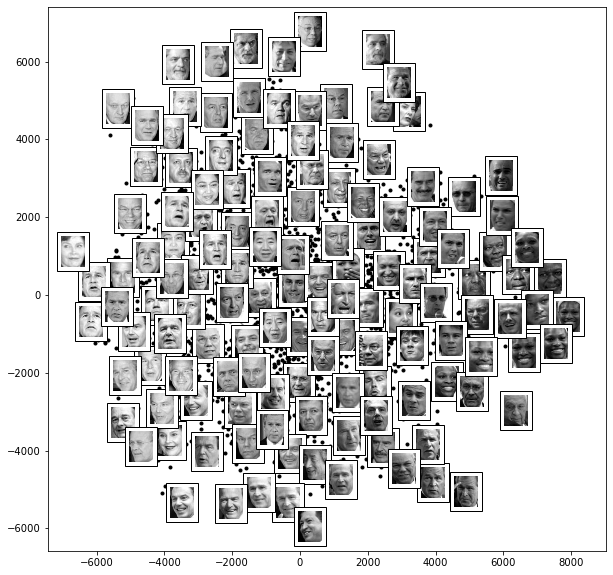

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2], cmap='gray')